<a href="https://colab.research.google.com/github/saadiqbal96/Income-Prediction-Project/blob/main/supervisedlearningproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # plotting helper (only for nicer visuals, optional)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42

# Print header
print("Environment ready. Random state =", RANDOM_STATE)

Environment ready. Random state = 42


In [25]:
# Try to load census.csv from working dir (Jupyter), otherwise prompt upload (Colab)
def load_census_csv():
    local_filename = 'census.csv'
    if os.path.exists(local_filename):
        print(f"Loading local file: {local_filename}")
        df = pd.read_csv(local_filename, header=None)
        return df
    else:
        # Try Colab-style upload if running in Colab environment
        try:
            from google.colab import files
            print("Local file not found — please upload the CSV (adult.data renamed to census.csv recommended).")
            uploaded = files.upload()
            filename = list(uploaded.keys())[0]
            print("Uploaded:", filename)
            df = pd.read_csv(filename, header=None)
            return df
        except Exception as e:
            raise FileNotFoundError("census.csv not found in working dir AND google.colab.files.upload unavailable. "
                                    "Place census.csv in the same folder as the notebook or run in Colab and upload the file.") from e

# Load data
data = load_census_csv()

Loading local file: census.csv


In [26]:
# Column names expected by the project
data.columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

# Strip whitespace from object columns (critical for matching labels)
for col in data.select_dtypes(include=['object']).columns:
    data[col] = data[col].str.strip()

# Replace ? or missing tokens with NaN (UCI dataset uses '?')
data.replace('?', np.nan, inplace=True)

# Show a quick summary
print("\nLoaded data shape:", data.shape)
print("Sample rows:")
display(data.head())


Loaded data shape: (32561, 15)
Sample rows:


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K



=== Data Exploration (Rubric) ===
Number of records: 32561
Number of individuals with income >50K: 7841
Number of individuals with income <=50K: 24720
Percentage of individuals with income >50K: 24.08%

Missing values per column:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


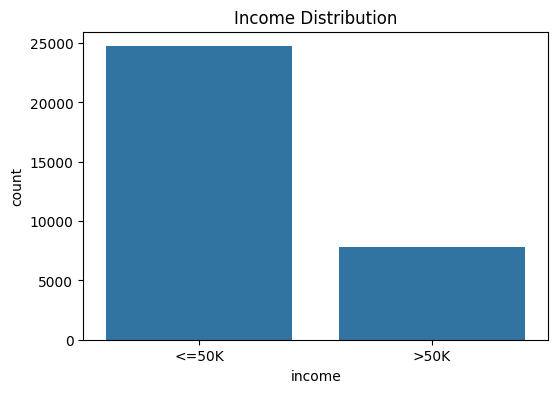

In [27]:
# (A) Basic counts required by rubric
num_records = data.shape[0]
num_income_gt_50k = (data['income'] == '>50K').sum()
num_income_le_50k = (data['income'] == '<=50K').sum()
pct_income_gt_50k = (num_income_gt_50k / num_records) * 100

print("\n=== Data Exploration (Rubric) ===")
print("Number of records:", num_records)
print("Number of individuals with income >50K:", num_income_gt_50k)
print("Number of individuals with income <=50K:", num_income_le_50k)
print("Percentage of individuals with income >50K: {:.2f}%".format(pct_income_gt_50k))

# (B) Quick distributions and missing values check
print("\nMissing values per column:")
print(data.isna().sum())

# Optional simple plots (comment out if running headless)
try:
    plt.figure(figsize=(6,4))
    sns.countplot(x='income', data=data)
    plt.title('Income Distribution')
    plt.show()
except Exception:
    pass

In [28]:
# Option: drop rows with missing values (simple approach) OR impute if desired
missing_threshold = 0  # set to >0 to allow some missingness
if data.isna().sum().sum() > 0:
    print("\nDropping rows with missing values (simple approach). Missing count:", data.isna().sum().sum())
    data = data.dropna().reset_index(drop=True)
    print("New shape after dropping missing rows:", data.shape)

# Recompute counts after cleaning (important)
num_records = data.shape[0]
num_income_gt_50k = (data['income'] == '>50K').sum()
num_income_le_50k = (data['income'] == '<=50K').sum()
pct_income_gt_50k = (num_income_gt_50k / num_records) * 100

# Separate features and target
X = data.drop('income', axis=1)
y = data['income'].map({'>50K':1, '<=50K':0})  # encode target

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# ColumnTransformer pipeline: One-hot encode categorical, scale numeric (fit on train later)
# Use OneHotEncoder(sparse_output=False, drop='first') per newer sklearn versions
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', ohe, categorical_cols)
], remainder='drop')

# Fit-transform the preprocessor on the training part later; but we will create X_preprocessed for convenience (fit on whole data now)
# NOTE: to avoid data leakage in real experiments, we should fit transformers only on the training set.
X_preprocessed_np = preprocessor.fit_transform(X)    # numpy array
# Get categorical feature names from fitted OHE
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
preprocessed_feature_names = numeric_cols + list(ohe_feature_names)
X_preprocessed = pd.DataFrame(X_preprocessed_np, columns=preprocessed_feature_names)

print("\nPreprocessed feature matrix shape:", X_preprocessed.shape)
display(X_preprocessed.head())


Dropping rows with missing values (simple approach). Missing count: 4262
New shape after dropping missing rows: (30162, 15)

Numeric columns: ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Preprocessed feature matrix shape: (30162, 96)


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,0.042796,-1.062722,1.128918,0.146092,-0.218586,-0.077734,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.880288,-1.007871,1.128918,-0.147445,-0.218586,-2.331531,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.033340,0.244693,-0.439738,-0.147445,-0.218586,-0.077734,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.108695,0.425240,-1.224066,-0.147445,-0.218586,-0.077734,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.794697,1.406658,1.128918,-0.147445,-0.218586,-0.077734,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("\nTrain/test split shapes:", X_train.shape, X_test.shape)


Train/test split shapes: (24129, 96) (6033, 96)


In [30]:
# Naive: predict everyone has income >50K (positive class)
y_naive_pred = np.ones_like(y_test)
acc_naive = accuracy_score(y_test, y_naive_pred)
f1_naive = f1_score(y_test, y_naive_pred)

print("\n=== Naive Predictor ===")
print("Accuracy (naive predicting all >50K): {:.4f}".format(acc_naive))
print("F1 score (naive): {:.4f}".format(f1_naive))


=== Naive Predictor ===
Accuracy (naive predicting all >50K): 0.2490
F1 score (naive): 0.3987


In [31]:
# We'll implement three models: Logistic Regression, Decision Tree, Random Forest
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

def evaluate_model(model, Xtr, Xte, ytr, yte):
    model.fit(Xtr, ytr)
    y_pred = model.predict(Xte)
    acc = accuracy_score(yte, y_pred)
    f1 = f1_score(yte, y_pred)
    return {'model': model, 'accuracy': acc, 'f1': f1, 'y_pred': y_pred}

results = {}
print("\n=== Training and initial evaluation of models ===")
for name, mdl in models.items():
    res = evaluate_model(mdl, X_train, X_test, y_train, y_test)
    results[name] = res
    print(f"\n{name}: Accuracy={res['accuracy']:.4f}, F1={res['f1']:.4f}")
    print("Classification report:")
    print(classification_report(y_test, res['y_pred']))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, res['y_pred']))


=== Training and initial evaluation of models ===

Logistic Regression: Accuracy=0.8473, F1=0.6635
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4531
           1       0.74      0.60      0.66      1502

    accuracy                           0.85      6033
   macro avg       0.81      0.77      0.78      6033
weighted avg       0.84      0.85      0.84      6033

Confusion matrix:
[[4204  327]
 [ 594  908]]

Decision Tree: Accuracy=0.8147, F1=0.6298
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      4531
           1       0.63      0.63      0.63      1502

    accuracy                           0.81      6033
   macro avg       0.75      0.75      0.75      6033
weighted avg       0.82      0.81      0.82      6033

Confusion matrix:
[[3964  567]
 [ 551  951]]

Random Forest: Accuracy=0.8487, F1=0.6712
Classification report:
 


Performance summary:
                      accuracy        f1
Logistic Regression  0.847340  0.663500
Decision Tree        0.814686  0.629801
Random Forest        0.848666  0.671228


<Figure size 800x400 with 0 Axes>

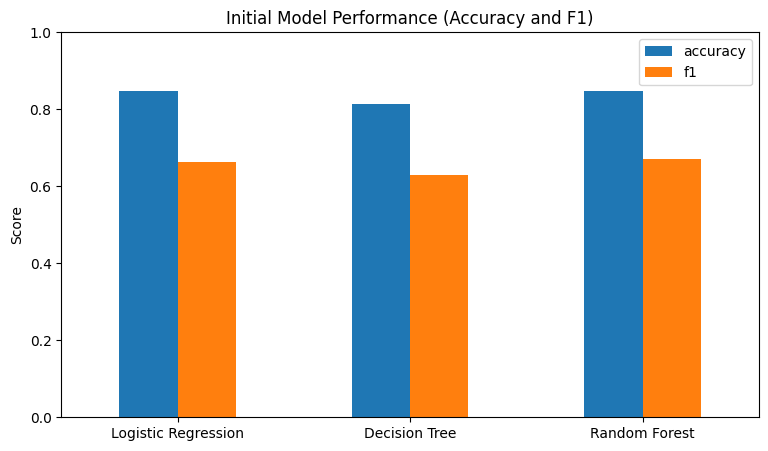

In [32]:
perf_df = pd.DataFrame({k: {'accuracy': v['accuracy'], 'f1': v['f1']} for k,v in results.items()}).T
print("\nPerformance summary:\n", perf_df)

# Bar plots for Accuracy and F1
plt.figure(figsize=(8,4))
perf_df[['accuracy','f1']].plot(kind='bar', figsize=(9,5))
plt.title('Initial Model Performance (Accuracy and F1)')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.show()

In [33]:
# We'll pick the best by F1 (or accuracy if you prefer) and discuss; create a small textual cell below.
best_model_name = perf_df['f1'].idxmax()
best_model_metrics = perf_df.loc[best_model_name].to_dict()
print(f"\nChosen best model by F1: {best_model_name} with metrics {best_model_metrics}")

# Layman's description (store for later display)
layman_description = {
    'Random Forest': "A Random Forest takes many decision trees (each a simple rule-based expert) and lets them vote. "
                     "Because many trees vote, mistakes by individual trees are evened out, producing a more reliable decision.",
    'Decision Tree': "A Decision Tree asks a sequence of yes/no questions (e.g., is education-num > X?) and follows branches to a prediction. "
                     "It's simple to visualize but prone to overfitting.",
    'Logistic Regression': "Logistic Regression is like fitting a weighted combination of features to estimate the probability of >50K; "
                           "it's fast and interpretable but may miss complex non-linear patterns."
}
print("\nLayman's explanation for the chosen model:")
print(layman_description.get(best_model_name, "Description not available."))


Chosen best model by F1: Random Forest with metrics {'accuracy': 0.8486656721365822, 'f1': 0.6712279438242708}

Layman's explanation for the chosen model:
A Random Forest takes many decision trees (each a simple rule-based expert) and lets them vote. Because many trees vote, mistakes by individual trees are evened out, producing a more reliable decision.


In [34]:
print("\n=== GridSearch (Random Forest tuning) ===")
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=RANDOM_STATE),
                       rf_param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid_rf.fit(X_train, y_train)
print("Best params:", grid_rf.best_params_)
print("Best CV F1:", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
y_best_pred = best_rf.predict(X_test)
best_acc = accuracy_score(y_test, y_best_pred)
best_f1 = f1_score(y_test, y_best_pred)
print("Test metrics of tuned RandomForest: Accuracy={:.4f}, F1={:.4f}".format(best_acc, best_f1))



=== GridSearch (Random Forest tuning) ===
Best params: {'max_depth': 20, 'n_estimators': 100}
Best CV F1: 0.6816396523716745
Test metrics of tuned RandomForest: Accuracy=0.8604, F1=0.6827


In [35]:
final_table = pd.DataFrame({
    'Model': ['Naive Predictor'] + list(results.keys()) + ['RandomForest (tuned)'],
    'Accuracy': [acc_naive] + [results[m]['accuracy'] for m in results] + [best_acc],
    'F1': [f1_naive] + [results[m]['f1'] for m in results] + [best_f1]
})
print("\n=== Final model comparison table ===")
display(final_table.style.format({"Accuracy":"{:.4f}", "F1":"{:.4f}"}))


=== Final model comparison table ===


,Model,Accuracy,F1
0,Naive Predictor,0.2490,0.3987
1,Logistic Regression,0.8473,0.6635
2,Decision Tree,0.8147,0.6298
3,Random Forest,0.8487,0.6712
4,RandomForest (tuned),0.8604,0.6827



Computing feature importances from tuned RandomForest...
Top 15 features by importance:


,0
capital-gain,0.145114
marital-status_Married-civ-spouse,0.116615
age,0.100733
education-num,0.081526
hours-per-week,0.065990
fnlwgt,0.063836
marital-status_Never-married,0.050438
capital-loss,0.043354
relationship_Not-in-family,0.027639
sex_Male,0.027396


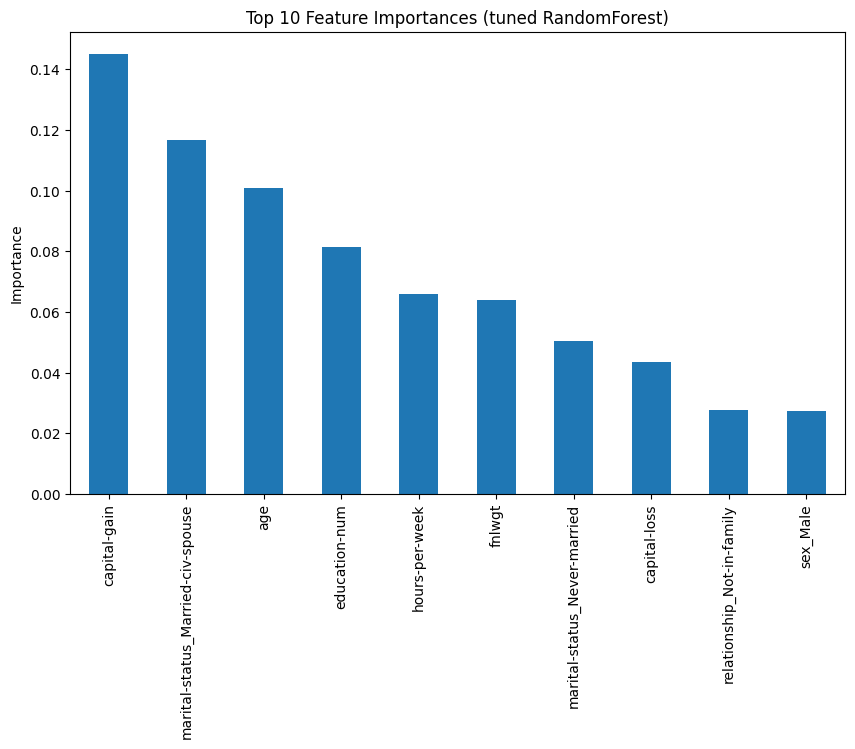

In [36]:
# Only tree-based models have feature_importances_ (RandomForest)
print("\nComputing feature importances from tuned RandomForest...")
rf_for_importance = best_rf  # tuned RF
importances = rf_for_importance.feature_importances_
feature_names = X_preprocessed.columns
feat_imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("Top 15 features by importance:")
display(feat_imp_series.head(15))

# Plot top 10
plt.figure(figsize=(10,6))
feat_imp_series.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (tuned RandomForest)')
plt.ylabel('Importance')
plt.show()

In [37]:
top5_features = feat_imp_series.head(5).index.tolist()
print("\nTop 5 features selected by model:", top5_features)

# Train RF only with top-5 features and compare
X_train_top5 = X_train[top5_features]
X_test_top5 = X_test[top5_features]
rf_top5 = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
rf_top5.fit(X_train_top5, y_train)
y_top5_pred = rf_top5.predict(X_test_top5)
acc_top5 = accuracy_score(y_test, y_top5_pred)
f1_top5 = f1_score(y_test, y_top5_pred)
print("Top-5 model test Accuracy: {:.4f}, F1: {:.4f}".format(acc_top5, f1_top5))


Top 5 features selected by model: ['capital-gain', 'marital-status_Married-civ-spouse', 'age', 'education-num', 'hours-per-week']
Top-5 model test Accuracy: 0.8303, F1: 0.6301


In [38]:
joblib.dump(best_rf, "best_random_forest.joblib")
print("\nSaved tuned RandomForest to 'best_random_forest.joblib'")


Saved tuned RandomForest to 'best_random_forest.joblib'


In [39]:
# We'll print template text with placeholders replaced by results so you can copy to markdown cells easily.
print("\n\n=== THEORETICAL ANSWERS (copy these into markdown cells & edit if you want) ===\n")

print("Question 1 — Naive Predictor Performance:\n")
print(f"- Naive predictor (predict everyone >50K) Accuracy = {acc_naive:.4f}, F1 = {f1_naive:.4f}.")
print("  This baseline must be beaten by the trained models for them to be useful.\n")

print("Question 2 — Model Application (pros/cons & references):\n")
print("Logistic Regression — Pros: fast, interpretable, low computational cost. Cons: may underperform with non-linearities and high-dimensional categorical data.")
print("Decision Tree — Pros: interpretable rules, no need to scale. Cons: overfitting risk, unstable.")
print("Random Forest — Pros: strong out-of-the-box performance, reduces variance, provides feature importances. Cons: higher compute cost, less interpretable.")
print("\nReferences:")
print("- Scikit-Learn documentation: https://scikit-learn.org")
print("- Udacity ML Nanodegree course materials\n")

print("Question 3 — Choosing the Best Model:\n")
print(f"- Based on test F1, the best performing model is {best_model_name} (F1 = {best_model_metrics['f1']:.4f}); after tuning, RandomForest achieved F1 = {best_f1:.4f} on the test set.")
print("  Considering computational cost and robustness, RandomForest is selected as the final model.\n")

print("Question 4 — Layman's description of RandomForest:\n")
print("- A Random Forest asks many simple 'if-then' questions (trees) and takes a majority vote to make a decision. This voting reduces mistakes from any single tree.\n")

print("Question 5 — Final Model Evaluation (table) — copy the table above into your report.\n")

print("Question 6 — Feature Relevance (my top-5 expected):")
print("- My expected top 5: education-num, hours-per-week, age, capital-gain, occupation (based on intuition about earnings).")
print("Question 7 — Extracted feature importances: (see printed top features above)\n")
print("Question 8 — Effects of Feature Selection:")
print(f"- Full tuned RandomForest: Accuracy={best_acc:.4f}, F1={best_f1:.4f}")
print(f"- RandomForest with top-5 features: Accuracy={acc_top5:.4f}, F1={f1_top5:.4f}")
print("  Interpret results: if top-5 performance is similar, a smaller model is viable; otherwise the excluded features add value.\n")




=== THEORETICAL ANSWERS (copy these into markdown cells & edit if you want) ===

Question 1 — Naive Predictor Performance:

- Naive predictor (predict everyone >50K) Accuracy = 0.2490, F1 = 0.3987.
  This baseline must be beaten by the trained models for them to be useful.

Question 2 — Model Application (pros/cons & references):

Logistic Regression — Pros: fast, interpretable, low computational cost. Cons: may underperform with non-linearities and high-dimensional categorical data.
Decision Tree — Pros: interpretable rules, no need to scale. Cons: overfitting risk, unstable.
Random Forest — Pros: strong out-of-the-box performance, reduces variance, provides feature importances. Cons: higher compute cost, less interpretable.

References:
- Scikit-Learn documentation: https://scikit-learn.org
- Udacity ML Nanodegree course materials

Question 3 — Choosing the Best Model:

- Based on test F1, the best performing model is Random Forest (F1 = 0.6712); after tuning, RandomForest achieved

In [40]:
# Save a CSV summary of final metrics (optional)
final_table.to_csv('model_comparison_summary.csv', index=False)
print("Saved 'model_comparison_summary.csv' with metrics.")

Saved 'model_comparison_summary.csv' with metrics.
